#### Análisis y Procesamiento de Señales

---

# Tarea Semanal N°9
## *Filtrado no lineal*

#### Augusto Colugnatti

---

## Introducción teórica

A raíz de la problemática que representa el ruido de baja frecuencia en las señales de ECG, sea en este caso el movimiento de línea de base, se propone realizar una serie de filtrados por metdologías no lineales.

→ **Filtro de mediana**

→ **Interpolación por Splines Cúbicos**

→ **Filtro adaptado**

---

## Desarrollo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from numpy.fft import fft
import scipy.signal as sp
import scipy.signal.windows as window
import scipy.stats as st
import scipy.io as sio
import scipy.interpolate as interpol
# from pytc2.sistemas_lineales import plot_plantilla

def matriz_confusion_qrs (mis_qrs, qrs_det, tolerancia_ms=150, fs=1000):
    
    """
    Calcula matriz de confusión para detecciones QRS usando solo NumPy y SciPy
    
    Parámetros:
    - mis_qrs: array con tiempos de tus detecciones (muestras)
    - qrs_det: array con tiempos de referencia (muestras)  
    - tolerancia_ms: tolerancia en milisegundos (default 150ms)
    - fs: frecuencia de muestreo (default 360 Hz)
    """
    
    # Convertir a arrays numpy
    mis_qrs = np.array(mis_qrs)
    qrs_det = np.array(qrs_det)
    
    # Convertir tolerancia a muestras
    tolerancia_muestras = tolerancia_ms * fs / 1000
    
    # Inicializar contadores
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    
    # Arrays para marcar detecciones ya emparejadas
    mis_qrs_emparejados = np.zeros(len(mis_qrs), dtype=bool)
    qrs_det_emparejados = np.zeros(len(qrs_det), dtype=bool)
    
    # Encontrar True Positives (detecciones que coinciden dentro de la tolerancia)
    for i, det in enumerate(mis_qrs):
        diferencias = np.abs(qrs_det - det)
        min_diff_idx = np.argmin(diferencias)
        min_diff = diferencias[min_diff_idx]
        
        if min_diff <= tolerancia_muestras and not qrs_det_emparejados[min_diff_idx]:
            TP += 1
            mis_qrs_emparejados[i] = True
            qrs_det_emparejados[min_diff_idx] = True
    
    # False Positives (tus detecciones no emparejadas)
    FP = np.sum(~mis_qrs_emparejados)
    FP_index = np.where(~mis_qrs_emparejados)[0]
    TP_index = np.where(mis_qrs_emparejados)[0]
    
    # False Negatives (detecciones de referencia no emparejadas)
    FN = np.sum(~qrs_det_emparejados)
    FN_index = np.where(~qrs_det_emparejados)[0]
    
    # Construir matriz de confusión
    matriz = np.array([
        [TP, FP],
        [FN, 0]  # TN generalmente no aplica en detección de eventos
    ])
    
    return matriz, TP, FP, FN, FP_index, FN_index, TP_index

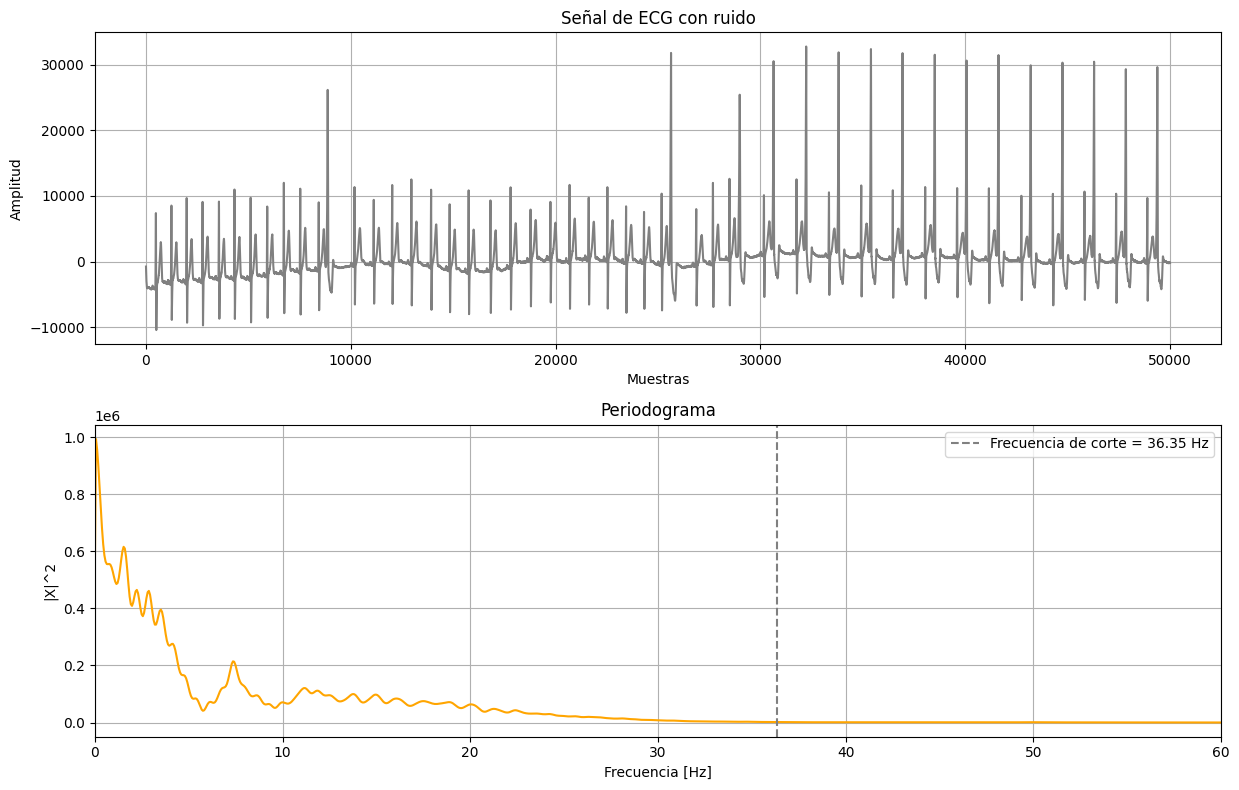

In [18]:
# ------------------------------- Señal de ECG con ruido ------------------------------- #

fs_ECG = 1000

# ECG = sio.whosmat ('./ECG_TP4.mat') # devuelve una lista de variables dentro del archivo .mat (MATLAB)
mat_struct = sio.loadmat ('./ECG_TP4.mat')
# print("Variables encontradas en el archivo .mat:", mat_struct.keys()) # esto muestra las variables dentro del archivo .mat (lo miro desde el explorador de variables)

ecg_one_lead = mat_struct ['ecg_lead'].ravel() # ECG con ruido

hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']

ECG_cr = ecg_one_lead[0:50000].ravel()

N_ECG_cr = len (ECG_cr)

df_ECG_cr = fs_ECG / N_ECG_cr
nn_ECG_cr = np.arange (N_ECG_cr)

promedios_ECG_cr = 16
nperseg_ECG_cr = N_ECG_cr // promedios_ECG_cr

ff_ECG_cr, per_ECG_cr = sp.welch (ECG_cr, nfft = 5*nperseg_ECG_cr, fs = fs_ECG, nperseg = nperseg_ECG_cr, window = 'flattop')

energia_acum_cr = np.cumsum (per_ECG_cr)
energia_acum_cr_norm = energia_acum_cr / energia_acum_cr[-1]
corte_ECG_cr = energia_acum_cr_norm[-1] * 0.995
indice_corte_cr = int (np.where (energia_acum_cr_norm >= corte_ECG_cr)[0][0])
frec_corte_cr = ff_ECG_cr[indice_corte_cr]

plt.figure (figsize=(12.5, 8))

plt.subplot (2, 1, 1)
plt.plot (nn_ECG_cr, ECG_cr, color='gray')
# plt.plot (ff_ECG_cr, 10*np.log10(np.abs(per_ECG_cr))) # representación en dB
plt.title ("Señal de ECG con ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_ECG_cr, per_ECG_cr, color='orange')
plt.axvline (frec_corte_cr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_cr:.2f} Hz')
plt.title ("Periodograma")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 60)

plt.tight_layout()
plt.show()

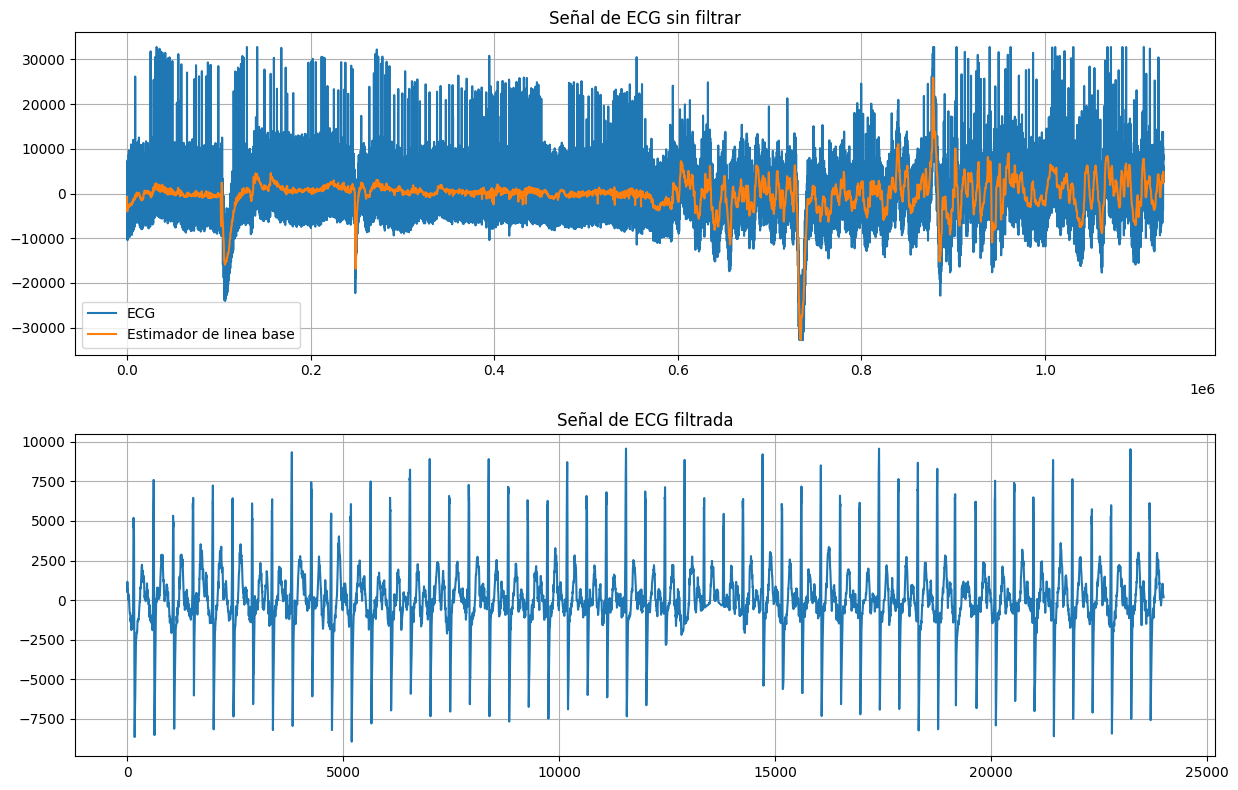

In [22]:
# ------------------------------------- Estimación por mediana ------------------------------------- #

estimador_med = sig.medfilt (sig.medfilt (ecg_one_lead, 201), 601)
ecg_estimada_med = ecg_one_lead - estimador_med

plt.figure (figsize = (12.5, 8))

plt.subplot (2, 1, 1)
plt.plot (ecg_one_lead, label='ECG')
plt.plot (estimador_med, label='Estimador de linea base')
plt.title ('Señal de ECG sin filtrar')
plt.legend ()
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ecg_estimada_med[720000:744000])
plt.title ('Señal de ECG filtrada')
plt.grid (True)

plt.tight_layout ()
plt.show ()

# todo artefacto producido por la NO LINEALIDAD (como las discontinuidades, picos) generan ensanchamiento del
# ancho de banda, y puede contaminar a la señal con energía en frecuencias que antes no tenían energía 


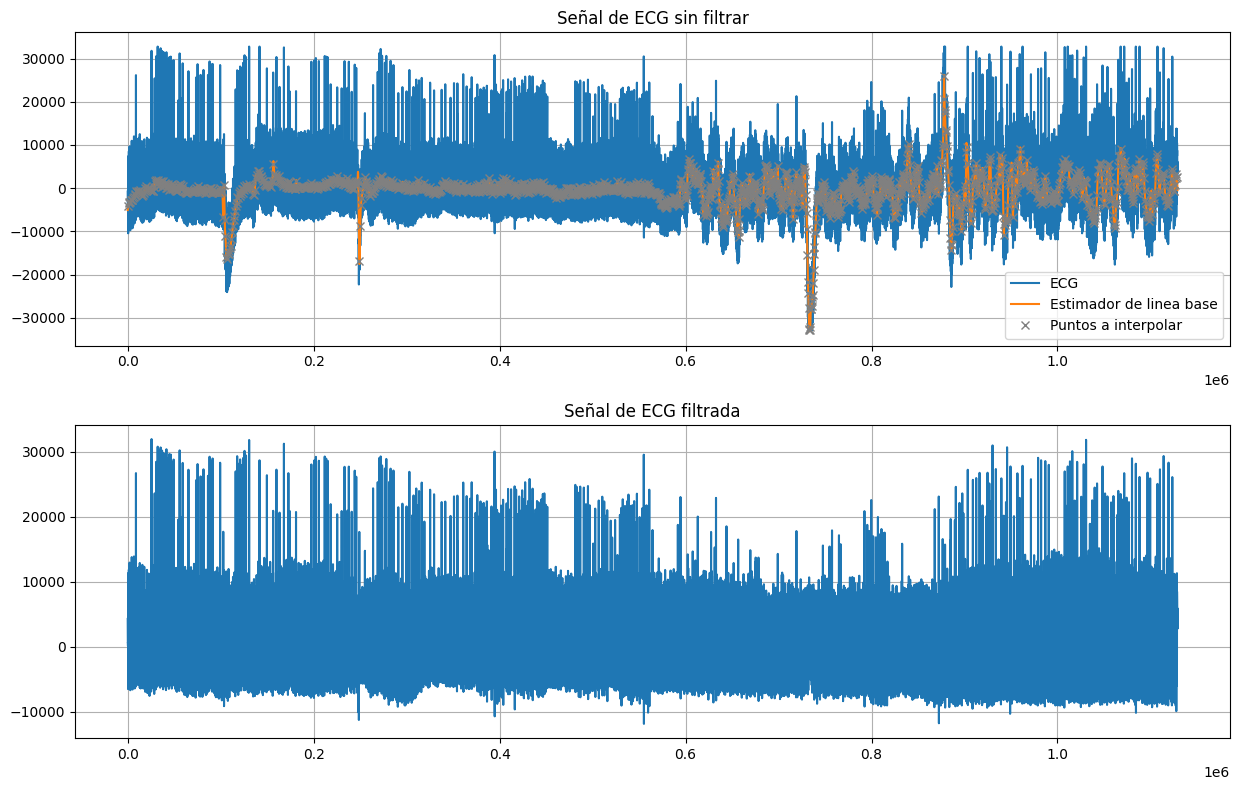

In [24]:
# ------------------------------------- Estimación por Splines Cúbicos ------------------------------------- #

qrs_x = mat_struct ['qrs_detections'].flatten() - 80
qrs_y = ecg_one_lead[qrs_x]

estimador_cs = interpol.CubicSpline (x = qrs_x, y = qrs_y)
ecg_estimada_cs = ecg_one_lead - estimador_cs(np.arange(len(ecg_one_lead)))

plt.figure (figsize = (12.5, 8))

plt.subplot (2, 1, 1)
plt.plot (ecg_one_lead, label='ECG')
plt.plot (estimador_cs(np.arange(len(ecg_one_lead))), label='Estimador de linea base')
plt.plot (qrs_x, qrs_y, marker='x', ls='', color='gray', label='Puntos a interpolar')
plt.title ('Señal de ECG sin filtrar')
plt.legend ()
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ecg_estimada_cs)
plt.title ('Señal de ECG filtrada')
plt.grid (True)

plt.tight_layout ()
plt.show ()

# plt.figure ()
# plt.plot (s[900000:912000], label='ECG', color='black')
# plt.plot (x[900000:912000], label='estimación')
# # plt.plot (qrs_x, qrs_y, marker='x', ls='', color='orchid')
# plt.legend ()

# un filtro derivador (resta muestras) es un pasa-altos, pues tiene un cero en DC (origen de coordenadas, plano S)
# que hace crecer al módulo a medida que w aumenta
# un promediador (suma muestras) es una filtro pasa-bajos

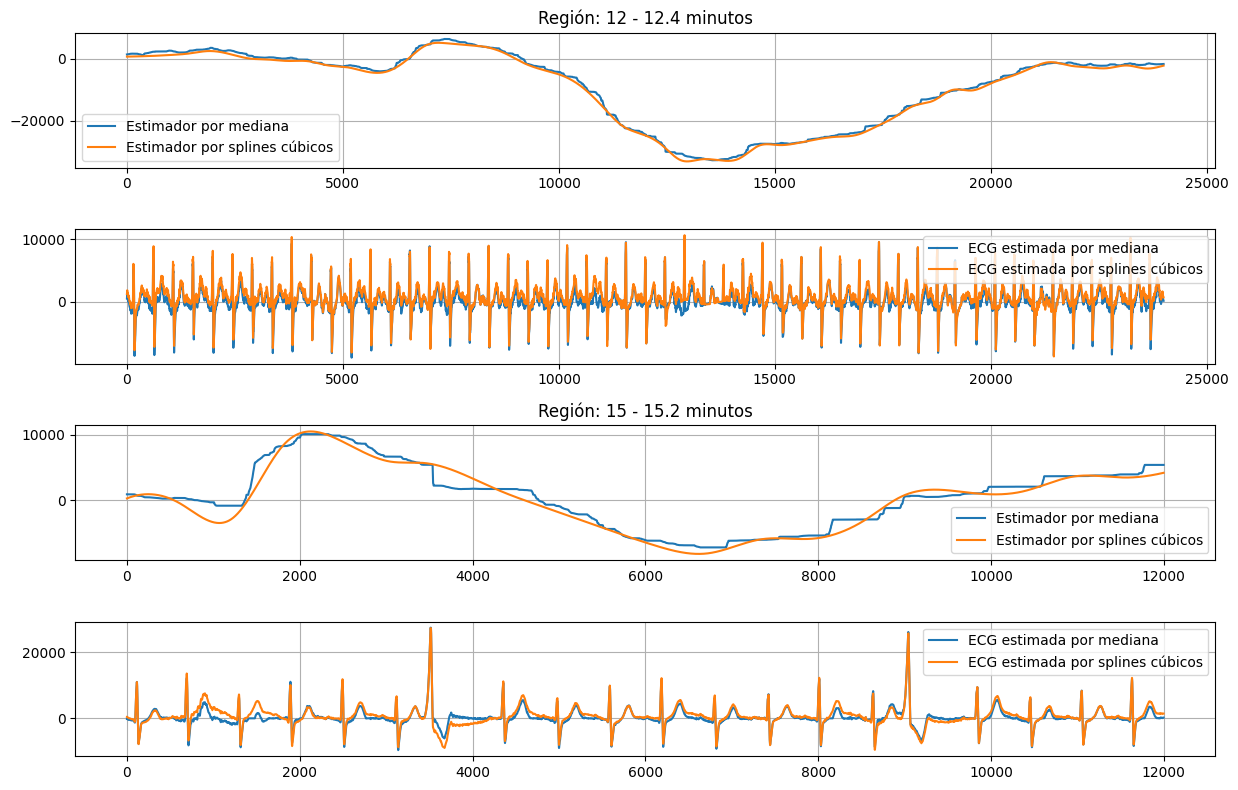

In [27]:
# ------------------------------------- Comparación de estimaciones ------------------------------------- #

plt.figure (figsize = (12.5, 8))

plt.subplot (4, 1, 1)
plt.plot (estimador_med[720000:744000], label='Estimador por mediana')
plt.plot (estimador_cs(np.arange(len(ecg_one_lead)))[720000:744000], label='Estimador por splines cúbicos')
plt.title ('Región: 12 - 12.4 minutos')
plt.legend ()
plt.grid (True)

plt.subplot (4, 1, 2)
plt.plot (ecg_estimada_med[720000:744000], label='ECG estimada por mediana')
plt.plot (ecg_estimada_cs[720000:744000], label='ECG estimada por splines cúbicos')
plt.legend ()
plt.grid (True)

plt.subplot (4, 1, 3)
plt.plot (estimador_med[900000:912000], label='Estimador por mediana')
plt.plot (estimador_cs(np.arange(len(ecg_one_lead)))[900000:912000], label='Estimador por splines cúbicos')
plt.title ('Región: 15 - 15.2 minutos')
plt.legend ()
plt.grid (True)

plt.subplot (4, 1, 4)
plt.plot (ecg_estimada_med[900000:912000], label='ECG estimada por mediana')
plt.plot (ecg_estimada_cs[900000:912000], label='ECG estimada por splines cúbicos')
plt.legend ()
plt.grid (True)

plt.tight_layout ()
plt.show ()


------- Matriz de Confusión -------
          Detectado
           Sí    No
Real Sí:  [1902    1]
Real No:  [ 2    - ]

TP: 1902, FP: 2, FN: 1
-----------------------------------

-------- Métricas --------
Precisión: 0.999
Sensibilidad: 0.999
F1-score: 0.999
--------------------------


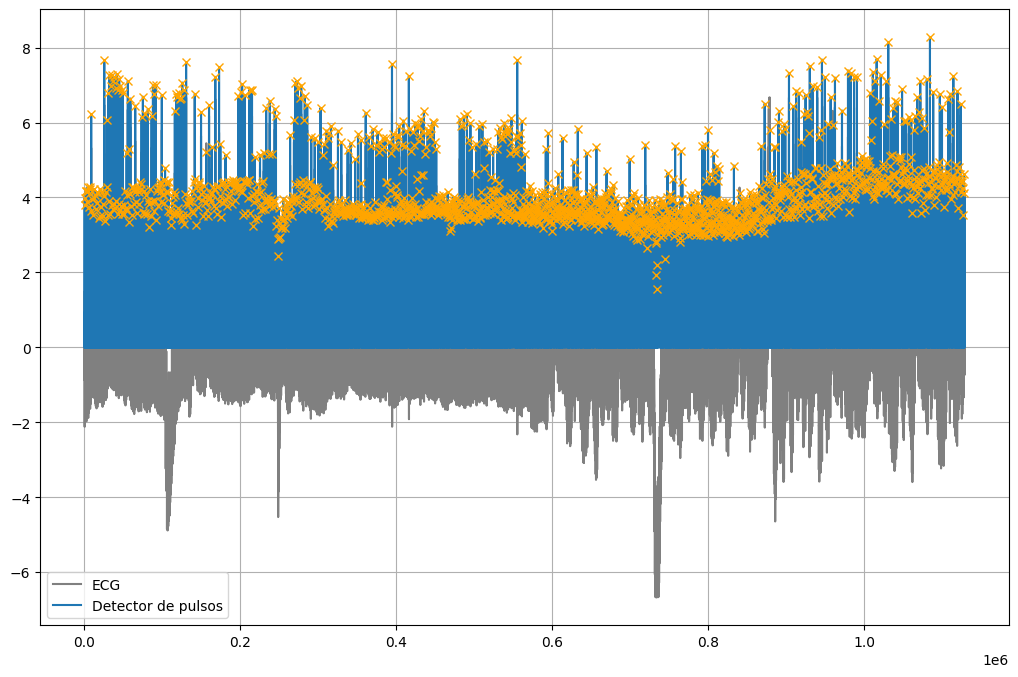

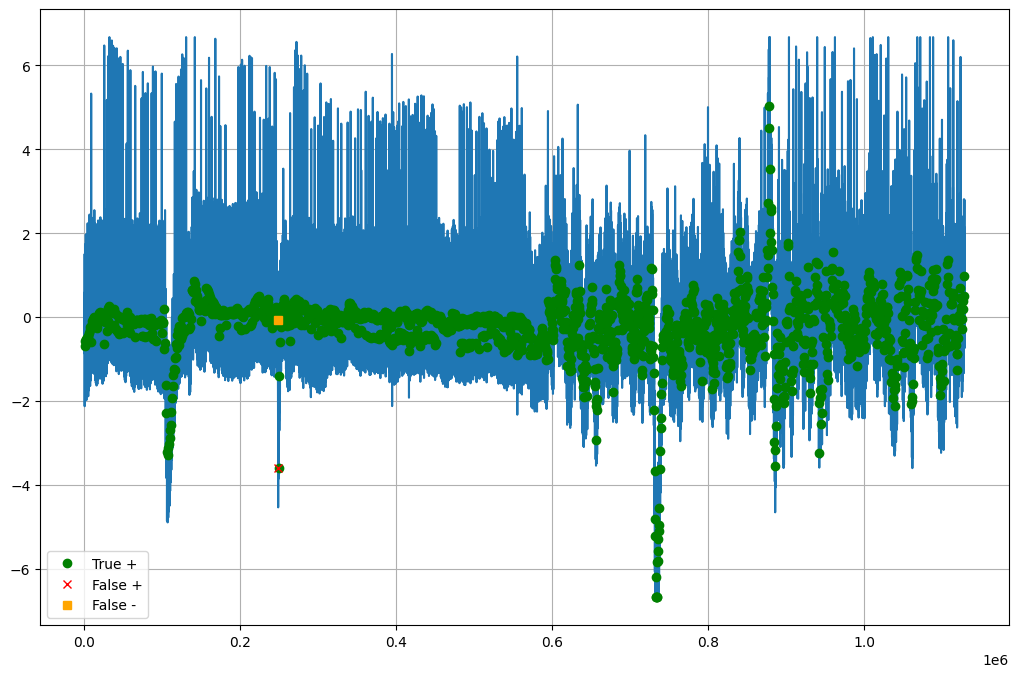

In [35]:
# ------------------------------------- Filtro adaptado ------------------------------------- #

det_ref = mat_struct ['qrs_detections'].ravel()

qrs_patt = mat_struct ['qrs_pattern1'].flatten()
qrs_patt = qrs_patt - np.mean(qrs_patt) # resto el valor medio para que tenga area neta nula, patron centrado en 0

ecg_norm = ecg_one_lead / np.std(ecg_one_lead)
# para que la varianza de una señal sea unitaria, debo escalar por el desvío estándar, esto se hace cuando quiero comparar dos señales de potencias muy diferidas

pulse_detect = sig.lfilter (b = qrs_patt, a = [1], x = ecg_one_lead.astype(np.float64)) # lfilter en el fondo convoluciona las señales, es similar a correlacionarlas
pulse_detect_norm = np.abs(pulse_detect) / np.std(pulse_detect)

beats, _ = sp.find_peaks (x = pulse_detect_norm, height = 1, distance = 300)

plt.figure (figsize=(12.5, 8))
plt.plot (ecg_norm, color='gray', label='ECG')
plt.plot (pulse_detect_norm[50:], label='Detector de pulsos') # con [50:] adelanto/retraso la señal para compensar la demora y alinearla con la ECG
plt.plot (beats, pulse_detect_norm[beats], ls='', marker='x', color='orange')
plt.grid (True)
plt.legend ()

mat_confusion, tp, fp, fn, fp_idx, fn_idx, tp_idx = matriz_confusion_qrs (mis_qrs = beats, qrs_det = det_ref)

# TP (true positive) -> valores que estaban en el gold standar (det_ref) y mi detector encontró
# FP (false positive) -> valores que NO estaban en el gold standar pero detecté erroneamente
# FN (false negative) -> valores que detecté y NO estaban en el gold standar

print("\n------- Matriz de Confusión -------")
print(f"          Detectado")
print(f"           Sí    No")
print(f"Real Sí:  [{tp:2d}   {fn:2d}]")
print(f"Real No:  [{fp:2d}    - ]")
print(f"\nTP: {tp}, FP: {fp}, FN: {fn}")
print("-----------------------------------")

# Calcular métricas de performance
if tp + fp > 0:
    precision = tp / (tp + fp) # la precisión mide el cociente entre mis detecciones acertadas y mis detecciones totales
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn) # o sensibilidad, mide el cociente entre mis detecciones acertadas y la totalidad de latidos (según gold standar)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall) # punto medio entre precisión y recall ponderado por el de menor valor
else:
    f1_score = 0

print("\n-------- Métricas --------")
print(f"Precisión: {precision:.3f}")
print(f"Sensibilidad: {recall:.3f}")
print(f"F1-score: {f1_score:.3f}")
print("--------------------------")

plt.figure (figsize=(12.5, 8))
plt.plot (ecg_norm)
plt.plot (beats[tp_idx], ecg_norm[beats[tp_idx]], ls='', marker='o', color='green', label='True +')
plt.plot (beats[fp_idx], ecg_norm[beats[fp_idx]], ls='', marker='x', color='red', label='False +')
plt.plot (det_ref[fn_idx], ecg_norm[beats[fn_idx]], ls='', marker='s', color='orange', label='False -')
plt.grid (True)
plt.legend ()

## Conclusiones